# Multiclass semantic segmentation using DeepLabV3+

**Author:** [Soumik Rakshit](http://github.com/soumik12345)<br>
**Date created:** 2021/08/31<br>
**Last modified:** 2021/09/1<br>
**Description:** Implement DeepLabV3+ architecture for Multi-class Semantic Segmentation.

## Introduction

Semantic segmentation, with the goal to assign semantic labels to every pixel in an image,
is an essential computer vision task. In this example, we implement
the **DeepLabV3+** model for multi-class semantic segmentation, a fully-convolutional
architecture that performs well on semantic segmentation benchmarks.

### References:

- [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)
- [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915)

## Downloading the data

We will use the [Crowd Instance-level Human Parsing Dataset](https://arxiv.org/abs/1811.12596)
for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images.
Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification.
This dataset can be used for the "human part segmentation" task.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-a0662c8c-7f30-d1db-d9e4-5fc4fa293df2)


In [4]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
if (False):
  !gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
  !unzip -q instance-level-human-parsing.zip

In [6]:
if False:
  !unzip -q secuencia.zip

In [7]:
#!unzip -q COLAB_instance-level-human-parsing2.zip

In [8]:
!date

Wed 09 Nov 2022 11:59:51 PM -03


In [9]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-11-09 23:59:51.545963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 23:59:51.564649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 23:59:51.564849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [10]:
!python -V


/bin/bash: python: command not found


In [11]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [12]:
#!rm -rf CelulasMix/
#!rm -rf CelulasR/
#!mkdir CelulasMix
#!mkdir CelulasR

In [13]:
!pip freeze

absl-py==1.2.0
alembic==1.8.1
anyio==3.6.1
apturl==0.5.2
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asttokens==2.0.5
astunparse==1.6.3
async-generator==1.10
attrs==22.1.0
Babel==2.10.3
backcall==0.2.0
bcrypt==3.1.7
beautifulsoup4==4.11.1
bleach==5.0.1
blinker==1.4
Brlapi==0.7.0
cachetools==5.2.0
certifi==2019.11.28
certipy==0.1.3
cffi==1.15.1
chardet==3.0.4
Click==7.0
colorama==0.4.3
command-not-found==0.3
cryptography==37.0.4
cupshelpers==1.0
cycler==0.11.0
dbus-python==1.2.16
debugpy==1.6.2
decorator==5.1.1
defer==1.0.6
defusedxml==0.7.1
distro==1.4.0
distro-info===0.23ubuntu1
duplicity==0.8.12.0
entrypoints==0.3
et-xmlfile==1.1.0
executing==0.9.1
fasteners==0.14.1
fastjsonschema==2.16.1
filelock==3.8.0
flatbuffers==1.12
fonttools==4.36.0
future==0.18.2
gast==0.4.0
gdown==4.5.3
google-auth==2.10.0
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
greenlet==1.1.2
grpcio==1.47.0
h5py==3.7.0
httplib2==0.14.0
idna==2.8
imageio==2.21.1
importlib-metadata==4.12.0
importlib-resources==5

## Creating a TensorFlow Dataset

Training on the entire CIHP dataset with 38,280 images takes a lot of time, hence we will be using
a smaller subset of 200 images for training our model in this example.

In [14]:
from PIL import Image
def func_ImageInfo(path):
    img1=Image.open(path)
    print("Mode: ", img1.mode)
    print("Palette",img1.palette)
    print("Format description: ",img1.format_description)
    print("Format: ", img1.format)
    print("Info: ",img1.info)    
    print("Size: ",img1.size)
    print("Max: ", np.max(img1), "Min: ",np.min(img1)) 
    
    print("")    

In [15]:
imgPruebaRaw=r"./instance-level_human_parsing/instance-level_human_parsing/Training/Images/0000006.jpg"
imgPruebaLabel=r"./instance-level_human_parsing/instance-level_human_parsing/Training/Category_ids/0000006.png"
imgPruebaRawHair=r"./HairDataset/raw/00000.jpg"
imgPruebaLabelHair=r"./HairDataset/label/00000_hair.png"
imgPruebaLabelHairOri=r"./HairDataset/labeloriginal/00000_hair.png"

imgPruebaRawPascal=r"./VOCtrainval_11-May-2012/VOC2012/JPEGImages/2007_000032.jpg"
imgPruebaLabelPascal=r"./VOCtrainval_11-May-2012/VOC2012/SegmentationClassAug/2007_000032.png"

imgPruebaRawEmbryo=r"./embryoDataset/video_animal2_proyeccion_Seq/video_animal2_proyeccion0000.jpg"
imgPruebaLabelEmbryo=r"./embryoDataset/EVLstack_Seq/EVL-stack0000.png"


In [16]:
func_ImageInfo(imgPruebaRaw)
func_ImageInfo(imgPruebaLabel)
func_ImageInfo(imgPruebaRawHair)
func_ImageInfo(imgPruebaLabelHair)
func_ImageInfo(imgPruebaLabelHairOri)
func_ImageInfo(imgPruebaRawPascal)
func_ImageInfo(imgPruebaLabelPascal)
print("embryo")
func_ImageInfo(imgPruebaRawEmbryo)
func_ImageInfo(imgPruebaLabelEmbryo)

Mode:  RGB
Palette None
Format description:  JPEG (ISO 10918)
Format:  JPEG
Info:  {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}
Size:  (335, 500)
Max:  255 Min:  0

Mode:  L
Palette None
Format description:  Portable network graphics
Format:  PNG
Info:  {}
Size:  (335, 500)
Max:  19 Min:  0

Mode:  RGB
Palette None
Format description:  JPEG (ISO 10918)
Format:  JPEG
Info:  {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}
Size:  (1024, 1024)
Max:  255 Min:  0

Mode:  L
Palette None
Format description:  Portable network graphics
Format:  PNG
Info:  {}
Size:  (512, 512)
Max:  1 Min:  0

Mode:  RGB
Palette None
Format description:  Portable network graphics
Format:  PNG
Info:  {}
Size:  (512, 512)
Max:  255 Min:  0

Mode:  RGB
Palette None
Format description:  JPEG (ISO 10918)
Format:  JPEG
Info:  {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}
Size:  (500, 281)
Max:  255 Min:  0

Mode:  L
Palette N

In [17]:
lst_Dimensiones=[496, 512, 880]

In [18]:
if True:  

  ILHP=False  
  embrion=True
  hair=False
  pascal=False
    
  if (pascal==True):
    IMAGE_SIZE = 512
    BATCH_SIZE = 4
    NUM_CLASSES = 22 #20 clases de objetos, la clase 0 es background, la clase ignore label es la clase 21 sumando 22 clases
    DATA_DIR = r"./VOCtrainval_11-May-2012/VOC2012"
    NUM_TRAIN_IMAGES = 10000 #Con 1000 anda bien
    NUM_VAL_IMAGES = 1000
    NUM_TEST_IMAGES = 1000
    carpetaRaw="JPEGImages"
    carpetaEtiquetas="SegmentationClassAug"
    EPOCAS=1000
  
  if (hair==True):
    IMAGE_SIZE = 512
    BATCH_SIZE = 4
    NUM_CLASSES = 2
    DATA_DIR = "./HairDataset"
    #NUM_TRAIN_IMAGES = 22400 #Con 1000 anda bien
    #NUM_VAL_IMAGES = 2800
    #NUM_TEST_IMAGES = 2800
    NUM_TRAIN_IMAGES = 400 #Con 1000 anda bien
    NUM_VAL_IMAGES = 50
    NUM_TEST_IMAGES = 10
    carpetaRaw="raw"
    carpetaEtiquetas="label"
    EPOCAS=100
  

  if (ILHP==True):
    IMAGE_SIZE = 512
    BATCH_SIZE = 4
    NUM_CLASSES = 20
    DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
    NUM_TRAIN_IMAGES = 22400 #Con 1000 anda bien
    NUM_VAL_IMAGES = 2800
    NUM_TEST_IMAGES = 2800
    carpetaRaw="Images"
    carpetaEtiquetas="Category_ids"
    EPOCAS=10000

  if (embrion==True):
    IMAGE_SIZE = 944#496, 512, 528, 544, 560, 576, 592, 608, 624, 640, 656, 672, 688, 704, 720, 736, 752, 768, 784, 800, 816, 832, 848, 864, 880, 896, 912, 928, 944, 960, 976
    BATCH_SIZE = 4
    NUM_CLASSES = 2
    DATA_DIR = "./embryoDataset"
    NUM_TRAIN_IMAGES = 60
    NUM_VAL_IMAGES = 50
    NUM_TEST_IMAGES = 10
    #carpetaRaw=r"video_animal2_proyeccion_Seq"
    carpetaRaw=r"video_animal2_proyeccion_Seq"
    carpetaEtiquetas=r"EVLstack_Seq"
    EPOCAS=30



  

  train_images = sorted(glob(os.path.join(DATA_DIR, carpetaRaw+"/*")))[:NUM_TRAIN_IMAGES]
  train_masks = sorted(glob(os.path.join(DATA_DIR, carpetaEtiquetas+"/*")))[:NUM_TRAIN_IMAGES]
  val_images = sorted(glob(os.path.join(DATA_DIR, carpetaRaw+"/*")))[
      NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
  ]
  val_masks = sorted(glob(os.path.join(DATA_DIR, carpetaEtiquetas+"/*")))[
      NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
  ]

  test_images = sorted(glob(os.path.join(DATA_DIR, carpetaRaw+"/*")))[
      NUM_VAL_IMAGES + NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES + NUM_TEST_IMAGES
  ]
  test_masks = sorted(glob(os.path.join(DATA_DIR, carpetaEtiquetas+"/*")))[
      NUM_VAL_IMAGES + NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES + NUM_TEST_IMAGES
  ]

  def read_image(image_path, mask=False):
      image = tf.io.read_file(image_path)
      if mask:
          image = tf.image.decode_png(image, channels=1)
          image.set_shape([None, None, 1])
          image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
      else:
          image = tf.image.decode_png(image, channels=3)
          image.set_shape([None, None, 3])
          image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
          image = image / 127.5 - 1
      return image


  def load_data(image_list, mask_list):
      image = read_image(image_list)
      mask = read_image(mask_list, mask=True)
      return image, mask


  def data_generator(image_list, mask_list):
      dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
      dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
      dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
      return dataset


  train_dataset = data_generator(train_images, train_masks)
  val_dataset = data_generator(val_images, val_masks)
  test_dataset = data_generator(test_images, test_masks)

  print("Train Dataset:", train_dataset)
  print("Val Dataset:", val_dataset)
  print("Test Dataset:", test_dataset)

  print(len(train_images))
  print(len(val_images))
  print(len(test_images))

  print("Cuando no encuentra archivos parece que salta este error: TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.")
  print("Ojo con NUM_TRAIN_IMAGES = 100 NUM_VAL_IMAGES = 10 NUM_TEST_IMAGES = 30. Si no hay suficientes imagenes salta este error: TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.")

2022-11-09 23:59:52.511552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 23:59:52.513852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 23:59:52.514047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 23:59:52.514164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 944, 944, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 944, 944, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 944, 944, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 944, 944, 1), dtype=tf.float32, name=None))>
Test Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 944, 944, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 944, 944, 1), dtype=tf.float32, name=None))>
60
50
10
Cuando no encuentra archivos parece que salta este error: TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.
Ojo con NUM_TRAIN_IMAGES = 100 NUM_VAL_IMAGES = 10 NUM_TEST_IMAGES = 30. Si no hay suficientes imagenes salta este error: TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


## Building the DeepLabV3+ model

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)

**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the
sampling rate becomes larger, the number of valid filter weights (i.e., weights that
are applied to the valid feature region, instead of padded zeros) becomes smaller.

In [19]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [20]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])#Esta es la que se enoja cuando no acepta cualquier dimension de imagen
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    #model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation="softmax")(x)
    return keras.Model(inputs=model_input, outputs=model_output)



In [21]:
def func_ImgSizeAdmitidas():
    lst_imagenesAdmitidas=[]
    i=0
    for i in range(0,1100):
        #print("IMAGE_SIZE: ",i)
        lst_imagenesAdmitidas.append(i)
        try:
            model = DeeplabV3Plus(image_size=i, num_classes=NUM_CLASSES)
        except:
            #print("IMAGE_SIZE: ",i,"error")
            del lst_imagenesAdmitidas[-1]
        i+=1
    
    return(lst_imagenesAdmitidas)

In [22]:
#func_ImgSizeAdmitidas()
#496, 512, 528, 544, 560, 576, 592, 608, 624, 640, 656, 672, 688, 704, 720, 736, 752, 768, 784, 800, 816, 832, 848, 864, 880, 896, 912, 928, 944, 960, 976, 992, 1008, 1024, 1040, 1056, 1072, 1088]

In [23]:
print("IMAGE_SIZE: ",IMAGE_SIZE)
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

IMAGE_SIZE:  944


In [24]:
#model.summary()

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Training

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

20221109_2359
Epoch 1/30


2022-11-09 23:59:57.896943: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-09 23:59:58.252402: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-09 23:59:59.407511: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-09 23:59:59.407567: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-09 23:59:59.407575: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

 5/15 [=========>....................] - ETA: 2s - loss: 0.4415 - accuracy: 0.7975

2022-11-10 00:00:02.096860: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 6/15 [===========>..................] - ETA: 2s - loss: 0.4249 - accuracy: 0.8085

2022-11-10 00:00:02.391285: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 7/15 [=============>................] - ETA: 2s - loss: 0.4109 - accuracy: 0.8156

2022-11-10 00:00:02.687371: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 9/15 [=================>............] - ETA: 1s - loss: 0.3830 - accuracy: 0.8293

2022-11-10 00:00:03.276529: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


10/15 [===================>..........] - ETA: 1s - loss: 0.3704 - accuracy: 0.8353

2022-11-10 00:00:03.571682: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


11/15 [=====================>........] - ETA: 1s - loss: 0.3589 - accuracy: 0.8404

2022-11-10 00:00:03.866720: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


15/15 [==============================] - 12s 411ms/step - loss: 0.3250 - accuracy: 0.8524 - val_loss: 1.8188 - val_accuracy: 0.3344
Epoch 2/30
15/15 [==============================] - 6s 375ms/step - loss: 0.1804 - accuracy: 0.9049 - val_loss: 1.9488 - val_accuracy: 0.7089
Epoch 3/30
15/15 [==============================] - 6s 374ms/step - loss: 0.1463 - accuracy: 0.9166 - val_loss: 1.3729 - val_accuracy: 0.8034
Epoch 4/30
15/15 [==============================] - 6s 375ms/step - loss: 0.1297 - accuracy: 0.9228 - val_loss: 1.0060 - val_accuracy: 0.8235
Epoch 5/30
15/15 [==============================] - 6s 375ms/step - loss: 0.1198 - accuracy: 0.9269 - val_loss: 0.7214 - val_accuracy: 0.8256
Epoch 6/30
15/15 [==============================] - 6s 376ms/step - loss: 0.1122 - accuracy: 0.9302 - val_loss: 0.5062 - val_accuracy: 0.8275
Epoch 7/30
15/15 [==============================] - 6s 376ms/step - loss: 0.1063 - accuracy: 0.9325 - val_loss: 0.3972 - val_accuracy: 0.8343
Epoch 8/30
15/15

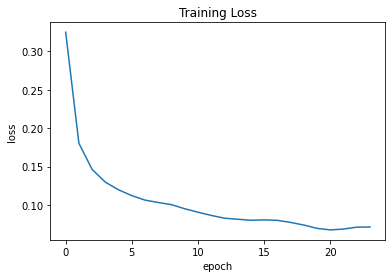

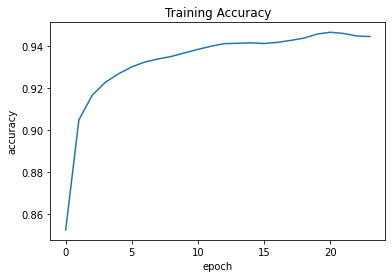

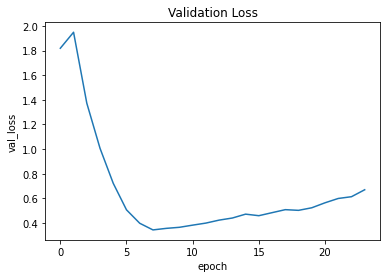

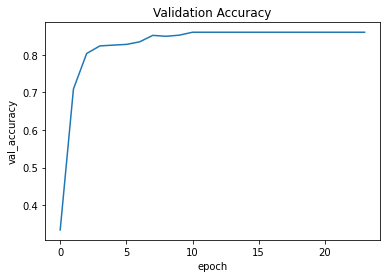

True
20221110_0002


In [26]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=["accuracy"],
)

from datetime import datetime as dt  
str_fecha=dt.today().strftime('%Y%m%d_%H%M')
print(str_fecha)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCAS, callbacks=[callback])#original son 25 epochs

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

print(embrion)
str_fecha=dt.today().strftime('%Y%m%d_%H%M')
print(str_fecha)

In [27]:
if False:
#if (embrion==True):  
  pathMio=r"./secuencia/raw/embryoR-10144.png"
  #from os.path import exists
  #print(r"exists:?",exists(pathMio))


  #auxIM = PIL.Image.open("./COLAB_instance-level-human-parsing2/Raw0.jpg")
  #pathMio=pathMio2
  #exists(r'./COLAB_instance-level-human-parsing2/embrion/secuencia/raw/embryoR-10000.png')

  print("OJO ESTA LINEA ES IMPORTANTE (LA DE ABAJO)")
  auxIM = tf.keras.utils.load_img(
      pathMio, target_size=(496, 496)
  )

  aux = tf.keras.utils.img_to_array(auxIM)
  aux = tf.expand_dims(aux, 0) # Create a batch

  #ACA PREDICE
  DCNNProbmapIn=model.predict(aux)


  DCNNProbmapIn=DCNNProbmapIn[0,:,:,:]


  #if True: #Para guardar imagenes     

  arr1A=DCNNProbmapIn[:,:,0]#La clase background
  arr2A=DCNNProbmapIn[:,:,1]#La clase embrion

  print(type(arr1A))

  from google.colab.patches import cv2_imshow
  cv2_imshow(arr1A*255)
  cv2_imshow(arr2A*255)
  

  print(np.unique(arr1A))
  print((arr1A).shape)
  print(arr1A.min())
  print(arr1A.max())

  print(arr2A.min())
  print(arr2A.max())
  #waits for user to press any key 
  #(this is necessary to avoid Python kernel form crashing)
  #cv2.waitKey(0) 
    
  #closing all open windows 
  #cv2.destroyAllWindows() 


  #cv2_imshow.("image", arr1A)
  #plt.show(arr1A)

In [28]:
savemodel=False
if(savemodel==True):
    # Save the entire model as a SavedModel.
    from datetime import datetime as dt  
    str_fecha=dt.today().strftime('%Y%m%d_%H%M')
    !mkdir -p saved_models
    model.save(r'saved_models/'+str_fecha+r"myModel")#

In [29]:
#model = tf.keras.models.load_model(r'saved_models/20221105_2229myModel')

In [30]:
#loss, acc = new_model.evaluate(test_dataset, verbose=2)

In [31]:
#loss, acc = model.evaluate(test_dataset, verbose=2)

In [32]:
#model.predict

In [33]:
if False:  
  #from PIL import Image
  #img = Image.open("Raw0.jpg").convert('L').resize((512, 512), Image.ANTIALIAS)
  #img = np.array(img)
  k = model.predict(test_dataset)
  print("Cantidad de imagenes, ancho, alto, clases",k.shape)
  print("Primera imagen: ")
  print(k[0].shape)#El maximo es 39. Con 40 se sale del array
  #print(k)

  print(k[0,:,:,0].shape)
  print(k[0,0,0,:])

  print(k[0,:,:,0].shape)
  print(k[1,0,0,:])

In [34]:
if False:  
  def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    print
    return pred_mask[0]

  #display([create_mask(k[0,:,:,:])])

In [35]:
if False:  
  from PIL import ImageOps
  def display_mask(i):
      """Quick utility to display a model's prediction."""
      mask = np.argmax(k[i,:,:,:], axis=-1)
      mask = np.expand_dims(mask, axis=-1)
      img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
      display(img)

In [36]:
if False:
  print(tf.config.list_physical_devices('GPU'))
  print(tf.test.is_gpu_available())

In [37]:
if False:
  print(test_images[35])
  display_mask(35)

  from PIL import Image
  img = Image.open(r"./instance-level_human_parsing/instance-level_human_parsing/Training/Images/0001361.jpg")
  display(img)

In [38]:
#model.predict(test_images)

In [39]:
#ejemplo = sorted(glob(os.path.join(DATA_DIR, "CelulasR/*")))[:1]
#print(ejemplo)
#image_example = tf.io.read_file("Raw0.jpg")

#image_example = tf.image.decode_jpeg(image_example, channels=3)
#image.set_shape([None, None, 3])
#image_exmple = tf.image.resize(images=image_exmple, size=[512, 512])
#image = image / 127.5 - 1

#print(image_example.shape)

#print(ejemplo)
#model.predict(image_example)

## Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [40]:
#if (embrion==False):  
if (True):  
  # Loading the Colormap
  colormap = loadmat(
      "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
  )["colormap"]
  colormap = colormap * 100
  colormap = colormap.astype(np.uint8)


  def infer(model, image_tensor):
      predictions = model.predict(np.expand_dims((image_tensor), axis=0))
      predictions = np.squeeze(predictions)
      predictions = np.argmax(predictions, axis=2)
      return predictions


  def decode_segmentation_masks(mask, colormap, n_classes):
      r = np.zeros_like(mask).astype(np.uint8)
      g = np.zeros_like(mask).astype(np.uint8)
      b = np.zeros_like(mask).astype(np.uint8)
      for l in range(0, n_classes):
          idx = mask == l
          r[idx] = colormap[l, 0]
          g[idx] = colormap[l, 1]
          b[idx] = colormap[l, 2]
      rgb = np.stack([r, g, b], axis=2)
      return rgb


  def get_overlay(image, colored_mask):
      image = tf.keras.preprocessing.image.array_to_img(image)
      image = np.array(image).astype(np.uint8)
      overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
      return overlay


  def plot_samples_matplotlib(display_list, figsize=(5, 3)):
      _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
      for i in range(len(display_list)):
          if display_list[i].shape[-1] == 3:
              axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
          else:
              axes[i].imshow(display_list[i])
      plt.show()


  def plot_predictions(images_list, colormap, model):
      for image_file in images_list:
          image_tensor = read_image(image_file)
          prediction_mask = infer(image_tensor=image_tensor, model=model)
          prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
          overlay = get_overlay(image_tensor, prediction_colormap)
          plot_samples_matplotlib(
              [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
          )


In [41]:
if False:
    model = tf.keras.models.load_model(r'saved_models/20221102_0635myModel')

### Inference on Train Images

1/1 [==============================] - 1s 973ms/step


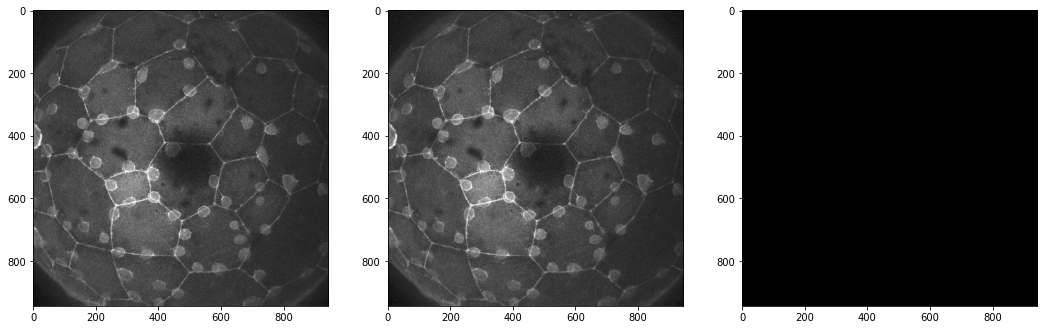

1/1 [==============================] - 0s 25ms/step


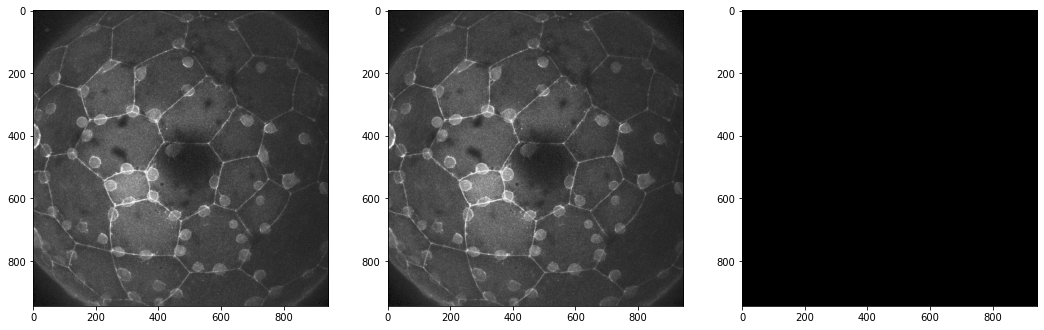

1/1 [==============================] - 0s 21ms/step


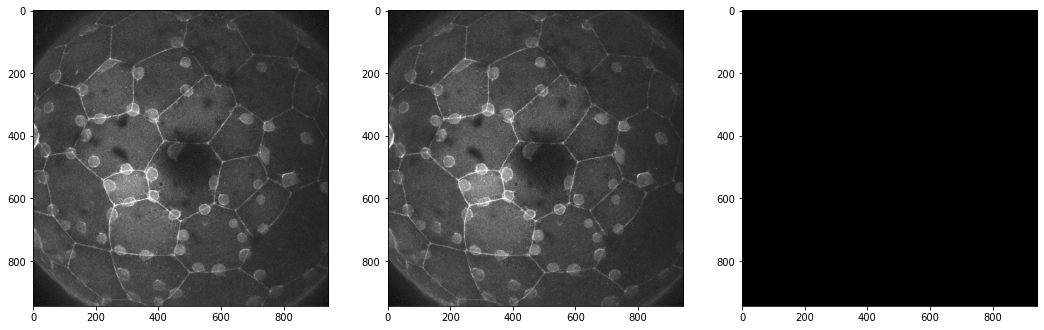

1/1 [==============================] - 0s 20ms/step


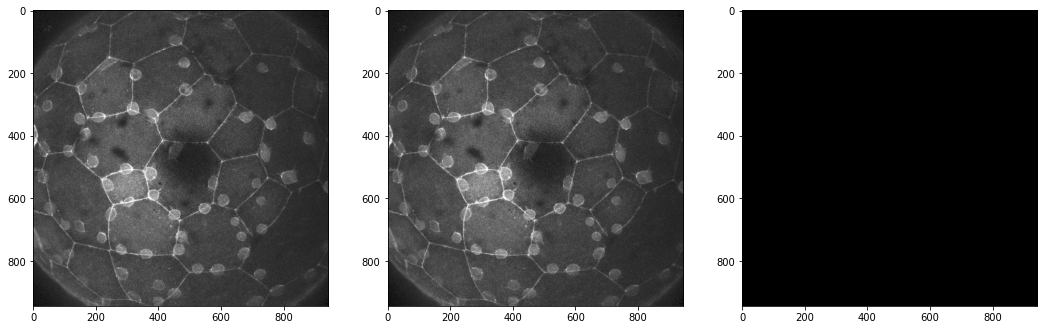

In [42]:
if True:
#if (embrion==False):
  #plot_predictions(train_images[:4], colormap, model=model)
  plot_predictions(test_images[:4], colormap, model=model)

### Inference on Validation Images

1/1 [==============================] - 0s 19ms/step


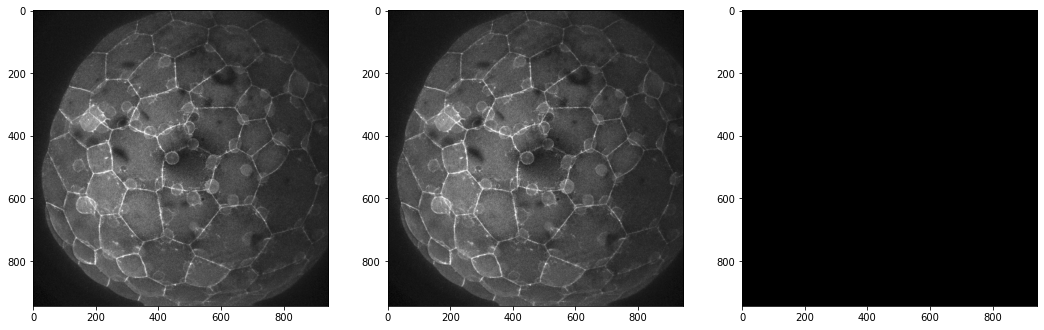

1/1 [==============================] - 0s 21ms/step


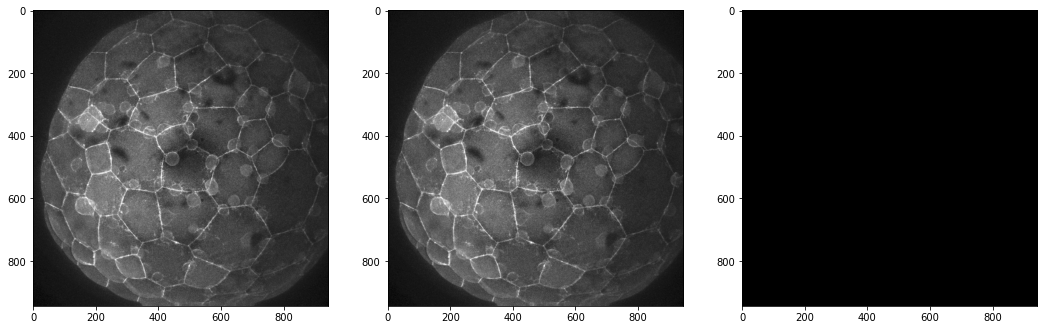

1/1 [==============================] - 0s 21ms/step


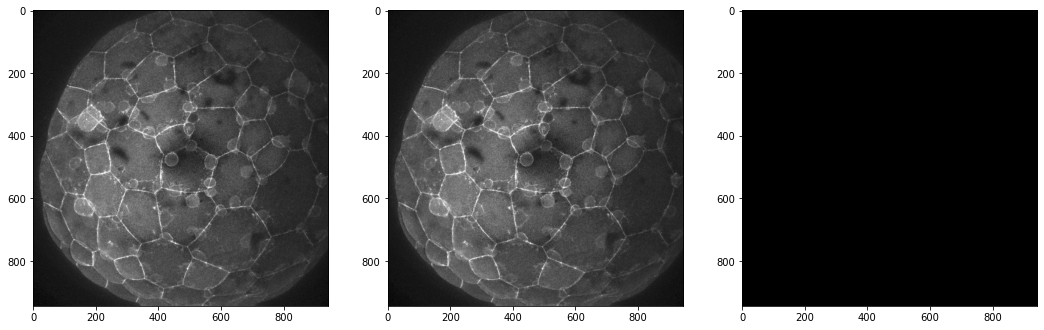

1/1 [==============================] - 0s 22ms/step


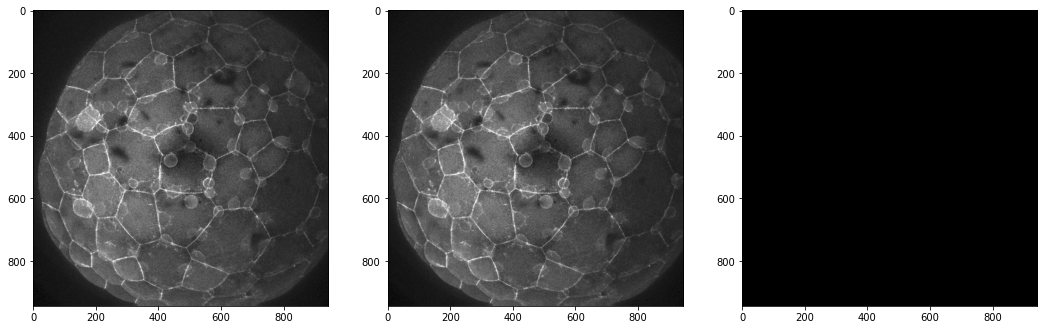

In [43]:
if True:
#if (embrion==False):  
  plot_predictions(val_images[:4], colormap, model=model)

In [44]:
!date

Thu 10 Nov 2022 12:02:22 AM -03


In [45]:
#!nvidia-smi

In [46]:
if True:
#if (embrion==False):  

  def infer(model, image_tensor):
      predictions = model.predict(np.expand_dims((image_tensor), axis=0))
      predictions = np.squeeze(predictions)
      predictions = np.argmax(predictions, axis=2)
      return predictions


  def calc_predictionsVBS(images_list, model):
      output=[]
      for image_file in images_list:
          image_tensor = read_image(image_file)
          prediction_mask = infer(image_tensor=image_tensor, model=model)
          output.append(prediction_mask)
      return(output)
          #prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
          #overlay = get_overlay(image_tensor, prediction_colormap)
          #plot_samples_matplotlib(
          #    [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
          #)


In [47]:
if True:
    def read_image(image_path, mask=False):
          image = tf.io.read_file(image_path)
          if mask:
              image = tf.image.decode_png(image, channels=1)
              image.set_shape([None, None, 1])
              image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
          else:
              image = tf.image.decode_png(image, channels=3)
              image.set_shape([None, None, 3])
              image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
              image = image / 127.5 - 1
          return image


    def load_dataVBS(image_list, mask, to_tensor):
        output=[]
        for image_list_i in image_list:
          image = read_image(image_list_i, mask)
          output.append(image)

        #if(to_tensor==True):
        #    output=tf.convert_to_tensor(output)
        return output

In [48]:
lst_preds=calc_predictionsVBS(test_images, model)

1/1 [==============================] - 0s 23ms/step


In [49]:
from PIL import Image
im = Image.fromarray((lst_preds[0]/19 * 255).astype(np.uint8), 'L')

im.show()

In [50]:
def normalizar(arrayIm):
    arrayIm=255*((arrayIm.max()-arrayIm.min())/arrayIm.max())
    arrayIm=arrayIm.astype(np.uint8)
    return(arrayIm)

display display: Unable to open X server ().


In [51]:
lst_preds[0].max()

0

In [52]:
a=lst_preds[0]

In [53]:
np.unique(lst_preds[0])

array([0])

In [54]:
#test_imagesIM = load_dataVBS(test_images, mask=False, to_tensor=False)
test_masksIM = load_dataVBS(test_masks, mask=True, to_tensor=False)

In [55]:
#type(test_imagesIM[0])

In [56]:
#output_pred=[]
#for test_imagesIM_i in test_imagesIM:
#    preds = model.predict(test_imagesIM_i)
#    output_pred.append(preds)

In [57]:
#preds=np.argmax(preds, axis=3)

In [58]:
#preds=tf.convert_to_tensor(preds)
#preds.shape

In [59]:
#lst_preds

In [60]:
#tf.keras.metrics.MeanIoU()

In [61]:
if (pascal==True):

    m = tf.keras.metrics.MeanIoU(num_classes=22)#Tensorflow 2.9 no tiene parametro ignore_label
    i=0
    for lst_preds_i in lst_preds: 
        #m.update_state(lst_preds[i] , test_masksIM[i])
        m.update_state(test_masksIM[i], lst_preds[i])
        #print(i)
        i+=1

    print(i)
    print(m.result().numpy()*100)

In [62]:
m = tf.keras.metrics.MeanIoU(num_classes=20)
i=0
for lst_preds_i in lst_preds: 
    #m.update_state(lst_preds[i] , test_masksIM[i])
    m.update_state(test_masksIM[i], lst_preds[i])
    #print(i)
    i+=1

print(i)
m.result().numpy()*100

10


46.127212047576904

In [63]:
print("miou: 22400 2800 2800 73(callback) (train, val, test, epoch)")
39.05654847621918

miou: 22400 2800 2800 73(callback) (train, val, test, epoch)


39.05654847621918

In [64]:
print("miou: 2000 200 200 26 (train, val, test, epoch)")
30.795103311538696

miou: 2000 200 200 26 (train, val, test, epoch)


30.795103311538696

In [65]:
print("miou: 1000 100 100 26 (train, val, test, epoch)")
27.59113609790802

miou: 1000 100 100 26 (train, val, test, epoch)


27.59113609790802

In [66]:
print("miou: 1000 100 100 1 (train, val, test, epoch)")
0.030545715

miou: 1000 100 100 1 (train, val, test, epoch)


0.030545715

In [67]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
udev            126G     0  126G   0% /dev
tmpfs            26G  2.6M   26G   1% /run
/dev/nvme1n1p1  447G  394G   31G  93% /
tmpfs           126G   76K  126G   1% /dev/shm
tmpfs           5.0M  4.0K  5.0M   1% /run/lock
tmpfs           126G     0  126G   0% /sys/fs/cgroup
/dev/loop0      128K  128K     0 100% /snap/bare/5
/dev/loop3       48M   48M     0 100% /snap/snapd/17029
/dev/loop2       92M   92M     0 100% /snap/gtk-common-themes/1535
/dev/loop4       48M   48M     0 100% /snap/snapd/17336
/dev/loop5      219M  219M     0 100% /snap/gnome-3-34-1804/72
/dev/loop6       46M   46M     0 100% /snap/snap-store/592
/dev/loop7       46M   46M     0 100% /snap/snap-store/599
/dev/loop10      66M   66M     0 100% /snap/gtk-common-themes/1519
/dev/loop8       56M   56M     0 100% /snap/core18/2566
/dev/loop14     347M  347M     0 100% /snap/gnome-3-38-2004/115
/dev/loop12     347M  347M     0 100% /snap/gnome-3-38-2004/119
/dev/loop11    